1. .join()裡面可放iterables
2. open
3. glob
4. unicodedata
5. string
6. __future

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/My Drive/space_Colab/data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Russian', 'Vietnamese', 'Portuguese', 'Arabic', 'Scottish', 'Italian', 'Chinese', 'Dutch', 'Czech', 'English', 'Korean', 'Irish', 'Japanese', 'Greek', 'Spanish', 'Polish', 'French', 'German']
O'Neal


In [ ]:
import torch, torch.nn as nn
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN,self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [ ]:
all_categories

['Russian',
 'Vietnamese',
 'Portuguese',
 'Arabic',
 'Scottish',
 'Italian',
 'Chinese',
 'Dutch',
 'Czech',
 'English',
 'Korean',
 'Irish',
 'Japanese',
 'Greek',
 'Spanish',
 'Polish',
 'French',
 'German']

In [ ]:
print(all_letters,'\n',all_letters.find('f'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'- 
 5


In [ ]:
n_letters

58

In [ ]:
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories) #1x18向量，在該category的位置數值=1
  tensor[0][li] = 1
  return tensor

def inputTensor(line):
  tensor = torch.zeros(len(line),1,n_letters) #單字長度x1x57的向量
  for li in range(len(line)):
    letter = line[li] #第幾個字母
    tensor[li][0][all_letters.find(letter)]=1 #將該字母轉成OHE
  return tensor

def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))] #獲得該單字每個字母轉化成index的list
  letter_indexes.append(n_letters - 1) #EOS 表示 end of sentence
  # print(letter_indexes)
  return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [ ]:
a,b,c = randomTrainingExample()
b.size(2)
c.unsqueeze_(-1)#target_line_tensor
c[2]

tensor([52])

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.0005
def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1) #1xn=>nx1
  hidden = rnn.initHidden()

  rnn.zero_grad()

  loss=0

  for i in range(input_line_tensor.size(0)): #.size(0)第0(+1)維的大小=>字母數
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
#讓NN學習手上有的名字資料的分布方式(自己學習參數)，之後再用來輸出
#output為1x59(letters數)向量, target_line_tensor[i]會得出一個數字tensor，該數字即為目標字母的index，NLL計算時就會把該index對應的output[index]取出來，再往後進行loss優化
    loss +=l                    

  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha = -learning_rate)

  return output, loss.item()/input_line_tensor.size(0)

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
n_letters

59

In [ ]:
rnn = RNN(n_letters, 128, n_letters) #input output 都是1x59的向量，代表一個字母

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1,n_iters+1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 16s (5000 5%) 2.8723
0m 32s (10000 10%) 2.6500
0m 48s (15000 15%) 3.0389
1m 4s (20000 20%) 3.6170
1m 21s (25000 25%) 1.7989
1m 37s (30000 30%) 2.7810
1m 53s (35000 35%) 2.1907
2m 9s (40000 40%) 2.6637
2m 25s (45000 45%) 3.0514
2m 41s (50000 50%) 2.0307
2m 57s (55000 55%) 2.6858
3m 14s (60000 60%) 3.0070
3m 30s (65000 65%) 2.2481
3m 46s (70000 70%) 2.1692
4m 2s (75000 75%) 2.7699
4m 19s (80000 80%) 3.3457
4m 35s (85000 85%) 1.8488
4m 52s (90000 90%) 2.0857
5m 8s (95000 95%) 2.0907
5m 24s (100000 100%) 1.6957


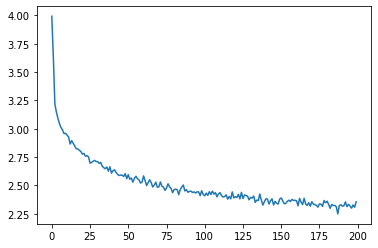

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20
# Sample from a category and starting letter
def sample(category, start_letter = 'B'):
  with torch.no_grad(): # no need to track history in sampling
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()
    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1) #output對應最大數值之字母輸出的值，及該字母的index
      topi = topi[0][0]
      if topi == n_letters -1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

    return output_name

sample('Chinese')

'Bain'